In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

Load account and save the backend/provider

In [3]:
provider = IBMQ.load_account()

In [4]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-research', group='milano-1', project='main')
jakarta = provider.get_backend('ibmq_jakarta')
# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

## Example of Trotterization

In [5]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [6]:
# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

In [7]:
# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

In [8]:
# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

In [9]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

## Alternative Trotterization - 1

In [10]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [13]:
def R_xyz(t):
    t_qr = QuantumRegister(2)
    t_qc = QuantumCircuit(t_qr, name='XYZ')
    
    t_qc.cnot(0,1)
    t_qc.rx(2*t-np.pi/2, 0)
    t_qc.rz(2 * t, 1)
    t_qc.h(0)
    t_qc.cnot(0,1)
    t_qc.h(0)
    t_qc.rz(-2 * t, 1)
    t_qc.cnot(0,1)
    t_qc.rx(np.pi/2,0)
    t_qc.rx(-np.pi/2,1)

    return t_qc

## Trotterize

In [27]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

### Standard
'''
for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])
'''
### Alternative 1

#for i in range(0, num_qubits - 1):
#    Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[i], Trot_qr[i+1]])

### Alternative 2

Trot_qc.append(R_xyz(2*t).to_instruction(), [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(R_xyz(3*t).to_instruction(), [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[0], Trot_qr[1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

## Study the circuit

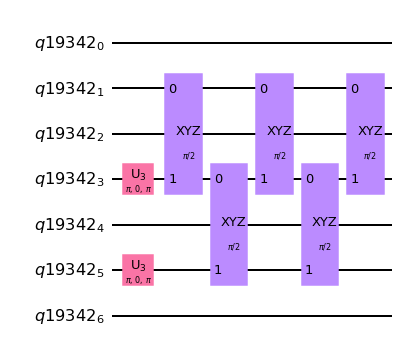

In [36]:
# The final time of the state evolution
target_time = 2*np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
## Standard and alternative 1

#for _ in range(trotter_steps):
#    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
## Alternative 2
qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps})

qc.decompose().draw(output="mpl")  # view decomposition of trotter gates
#qc.draw(output="mpl")  # only view trotter gates

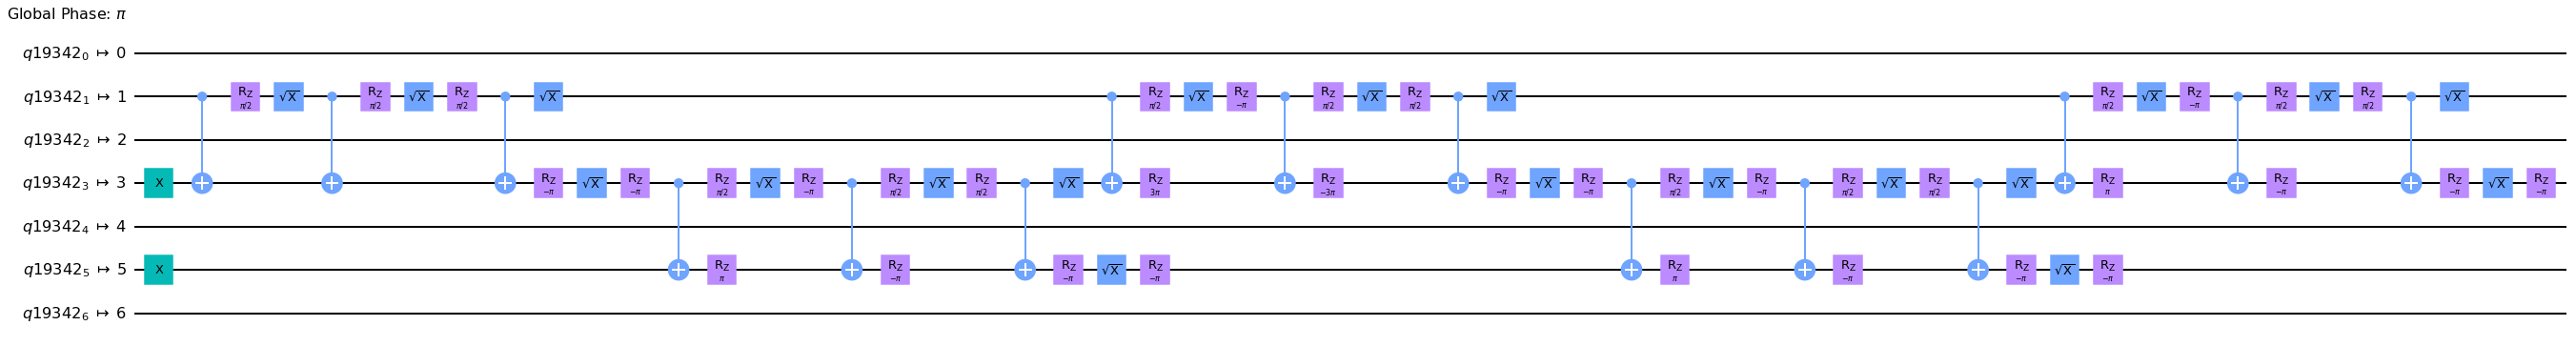

In [37]:
## Now we want to see the tanspiled circuit

transpiled_qc = transpile(qc, backend=jakarta)
transpiled_qc.draw(output="mpl",fold=-1)

In [38]:
print('depth: {}, #cx: {}, #sx: {}'.format(transpiled_qc.depth(), transpiled_qc.count_ops()['cx'], transpiled_qc.count_ops()['sx']))

depth: 56, #cx: 15, #sx: 20


circuit duration (s):  6.0728888888888885e-06


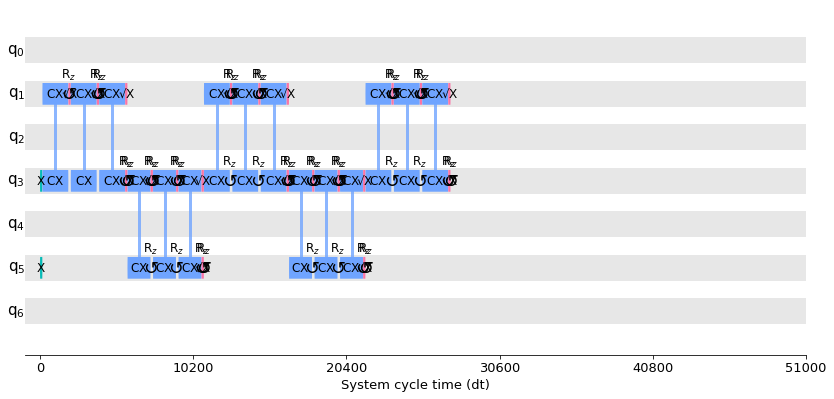

In [39]:
from qiskit.visualization import timeline_drawer
out = transpile(qc,
                backend=jakarta,
                scheduling_method='asap')
print('circuit duration (s): ', out.duration * jakarta.configuration().dt)
timeline_drawer(out, time_range=(0, 50000))

## State Tomography

/opt/anaconda3/envs/qiskit_0.32.1/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


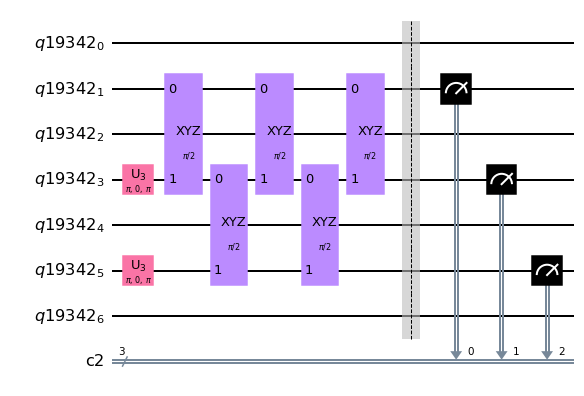

In [40]:
# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])


# Display circuit for confirmation
st_qcs[-1].decompose().draw(output="mpl")  # view decomposition of trotter gates
#st_qcs[-1].draw(output="mpl")  # only view trotter gates

## Evaluate circuit

In [41]:
shots = 8192
reps = 8
backend = sim_noisy_jakarta
# reps = 8
# backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 3a3171fd-07bd-444b-9786-28cc233219fd
Job ID 8c053fa3-4a22-4f44-ad69-29a1249a6ace
Job ID 6e866d30-a06d-494d-a639-23f6c76d5503
Job ID a0442333-521b-4d8a-adab-5694c1534ba4
Job ID 4d807615-9945-4b93-94bd-861b474b788b
Job ID 54435dd4-3072-4569-9df0-ce8ba53a4a3d
Job ID 6e5c33a2-7acf-475a-83d0-9658a4d5191c
Job ID 4f05e8fb-efe5-4635-a545-1366de7296b6


In [42]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


## Result analysis

In [43]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.7948 ± 0.0017
